### WGU D213 Advanced Data Analytics
# Task 2 - Sentiment Analysis Using Neural Networks

#### Ednalyn C. De Dios
#### August 27, 2023


# Environment

- Python: 3.9.9
- Jupyter: 7.0.2

# Part I. Research Question

## A1.  Summarize one research question that you will answer using neural network models and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen data set(s).

> ### _Can we predict the sentiment of a comment using previous comments?_

## A2. Define the objectives or goals of the data analysis. Be sure the objectives or goals are reasonable within the scope of the research question and are represented in the available data.

The objective of this analysis is to build and train a model that can predict whether a comment is favorable or not.

## A3. Identify a type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected data set.

For this analysis, we will use a special kind of Recurrent Neural Networks (RNN) called Long Short-Term Memory or LSTM.

In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

# for manipulating dataframes
import pandas as pd
import numpy as np

# natural language processing
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read tsv data
colnames=['text', 'label'] 
df_amazon = pd.read_csv('../data/amazon_cells_labelled.txt', sep='\t', names=colnames, header=None)
df_imdb = pd.read_csv('../data/imdb_labelled.txt', sep='\t', names=colnames, header=None)
df_yelp = pd.read_csv('../data/yelp_labelled.txt', sep='\t', names=colnames, header=None)
df = pd.concat([df_amazon, df_imdb, df_yelp])
df = df.reset_index(drop=True)

In [3]:
df.shape

(2748, 2)

In [4]:
df.head()
df.tail()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


,text,label
2743,I think food should have flavor and texture and both were lacking.,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


# Part II. Data Preparation

## B1.  Perform exploratory data analysis on the chosen data set, and include an explanation of each of the following elements:

- presence of unusual characters (e.g., emojis, non-English characters) - **We used regex to see if there are any non-english characters in the data set.**
- vocabulary size - **The vocabulary size is 4967. The value_counts() method was used to count the vocabulary size. Note this is done after removing stop words first.**
- proposed word embedding length - **The proposed word embedding length is 8 and has been derived from taking the square root of the square root of the vocabulary size.**
- statistical justification for the chosen maximum sequence length - **The mean of the list of lengths for each sentence was used to calculate the maximum sequence length.**

In [5]:
def isEnglish(c):
    try:
        c.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [6]:
non_english = []
for index, row in df.iterrows():
    for l in list(row['text']):
        for c in l:
            if isEnglish(c) == True:
                pass
            else:
                non_english.append(c)
non_english[:10]

['\x96', 'é', '\x85', '\x96', 'é', 'é', 'å', '\x96', '\x97', '\x96']

In [7]:
ADDITIONAL_STOPWORDS = []

def clean_sentence(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', sentence).split()
    word_list = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return word_list

In [8]:
def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    cleaned words that is returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (series): A pandas series

            Returns:
                    word_list (list): A list of cleaned words
    """
    return clean_sentence(''.join(str(df[column].tolist())))

In [9]:
df_csat =  df.loc[df['label'] == 1]
df_dsat =  df.loc[df['label'] == 0]

In [10]:
all_words = get_words(df, 'text')
csat_words = get_words(df_csat, 'text')
dsat_words = get_words(df_dsat, 'text')

In [11]:
csat_freq = pd.Series(csat_words).value_counts()
dsat_freq = pd.Series(dsat_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [12]:
vocab_size = len(all_freq)
print('Vocabulary size: ' + str(vocab_size))

Vocabulary size: 4967


In [13]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

show_missing(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
text,0,0.0,0,0.0,0,0.0
label,0,0.0,0,0.0,0,0.0


In [14]:
word_counts = (pd.concat([all_freq, csat_freq, dsat_freq], axis=1, sort=True)
                .set_axis(['all', 'csat', 'dsat'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

# What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,csat,dsat
good,226,170,56
movie,208,101,107
great,205,188,17
film,182,96,86
phone,173,91,82
one,145,69,76
time,133,57,76
like,127,61,66
food,125,60,65
place,123,62,61


In [15]:
# Are there any words that uniquely identify a dsat or csat comment?
pd.concat([word_counts[word_counts.dsat == 0].sort_values(by='csat').tail(10),
           word_counts[word_counts.csat == 0].sort_values(by='dsat').tail(10)])

,all,csat,dsat
priced,7,7,0
town,7,7,0
joy,7,7,0
superb,7,7,0
brilliant,7,7,0
role,9,9,0
pleased,10,10,0
interesting,15,15,0
fantastic,18,18,0
delicious,23,23,0


In [16]:
def get_unigrams(words):
    """
    Takes in a list of words and returns a series of
    unigrams with value counts.
    """
    return  pd.Series(words).value_counts()

def get_bigrams(words):
    """
    Takes in a list of words and returns a series of
    bigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

def get_trigrams(words):
    """
    Takes in a list of words and returns a series of
    trigrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

def get_qualgrams(words):
    """
    Takes in a list of words and returns a series of
    qualgrams with value counts.
    """
    return (pd.Series(nltk.ngrams(words, 4)).value_counts())[:20]

def get_ngrams(df,column):
    """
    Takes in a dataframe with column name and generates a
    dataframe of unigrams, bigrams, trigrams, and qualgrams.
    """
    return get_bigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'bigram','0':'count'}), \
           get_trigrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'trigram','0':'count'}), \
           get_qualgrams(get_words(df,column)).to_frame().reset_index().rename(columns={'index':'qualgram','0':'count'})

In [17]:
def viz_bigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of bigrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

def viz_trigrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of trigrams.
    """
    get_trigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')
    
def viz_qualgrams(df, column, title):
    """
    Takes in a dataframe, target column name, and specified title
    for the bar chart visualization of qualgrams.
    """
    get_bigrams(get_words(df,column)).sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))

    plt.title(title)
    plt.ylabel('Qualgram')
    plt.xlabel('# Occurances')

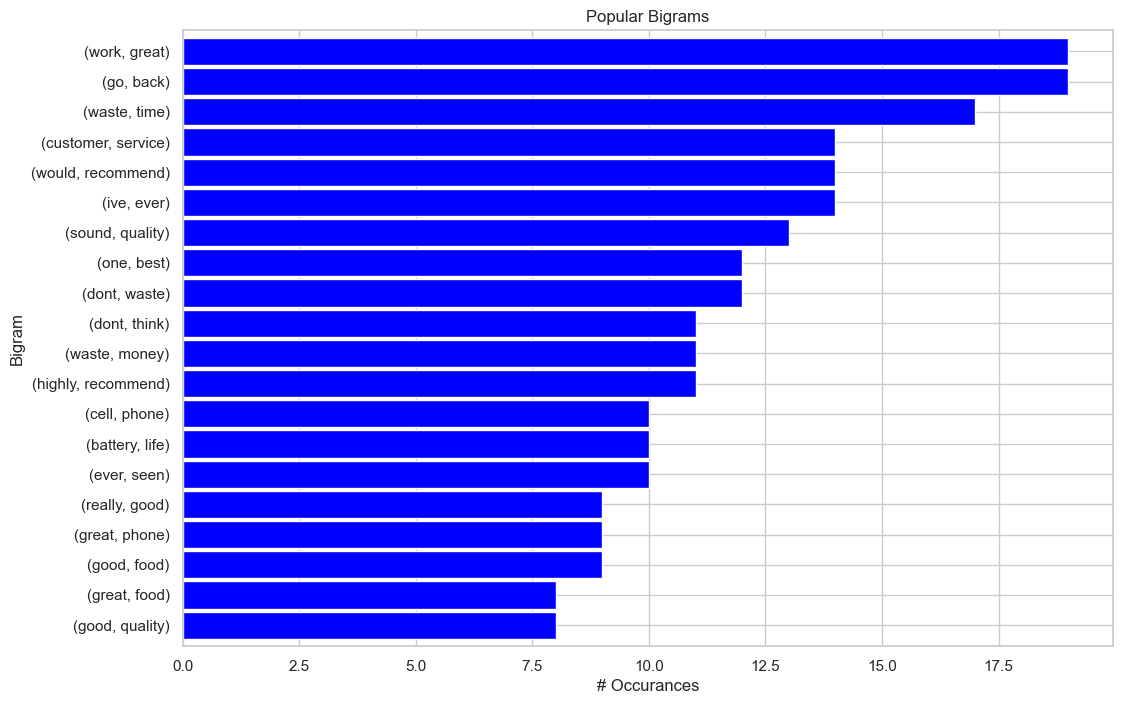

In [18]:
viz_bigrams(df, 'text', 'Popular Bigrams')

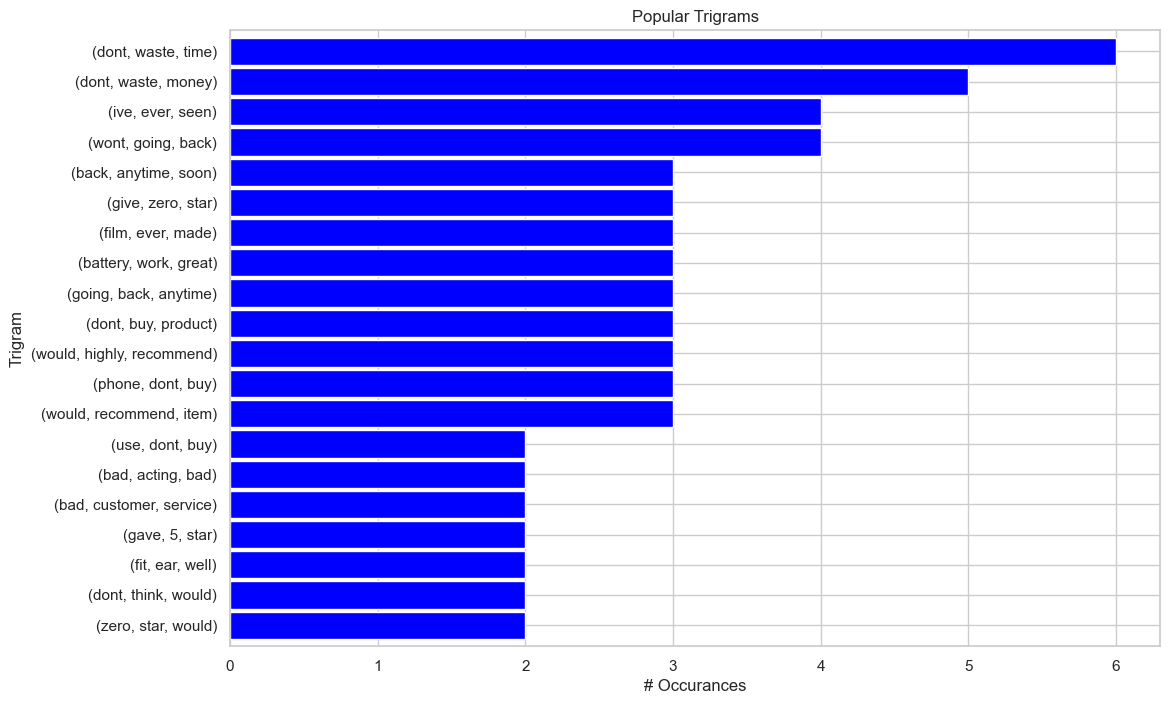

In [19]:
viz_trigrams(df, 'text', 'Popular Trigrams')

In [20]:
df.head()
df.tail()

,text,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


,text,label
2743,I think food should have flavor and texture and both were lacking.,0
2744,Appetite instantly gone.,0
2745,Overall I was not impressed and would not go back.,0
2746,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
2747,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


In [21]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Max sequence embedding: ' + str(max_sequence_embedding))

Max sequence embedding: 8


In [22]:
list_of_lens = []
for index, row in df.iterrows():
    list_of_lens.append(len(clean_sentence(row['text'])))
sequence_length = max(list_of_lens)
print('Sequence length: ' + str(sequence_length))

Sequence length: 789


In [23]:
mean_sequence_length = int(round(np.mean(list_of_lens), 0))
print('Mean sequence length: ' + str(mean_sequence_length))

Mean sequence length: 7


## B2.  Describe the goals of the tokenization process, including any code generated and packages that are used to normalize text during the tokenization process.

One goal of tokenization process is to separate the sentences into an array of words and then to an array of numbers. In this analysis, the tokenization process also included lemmatization, removal of stopwords, normalization, encoding, decoding, removal of special characters, and capitalization.

In [24]:
df['cleaned_text'] = df["text"].apply(clean_sentence)

In [25]:
df.head()

,text,label,cleaned_text
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,"[way, plug, u, unless, go, converter]"
1,"Good case, Excellent value.",1,"[good, case, excellent, value]"
2,Great for the jawbone.,1,"[great, jawbone]"
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,"[tied, charger, conversation, lasting, 45, minutesmajor, problem]"
4,The mic is great.,1,"[mic, great]"


In [26]:
def listToString(s): 
    string = " "
    return (string.join(s)) 

In [27]:
df['super_cleaned_text'] = df['cleaned_text'].apply(listToString)

In [28]:
df.head()

,text,label,cleaned_text,super_cleaned_text
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,"[way, plug, u, unless, go, converter]",way plug u unless go converter
1,"Good case, Excellent value.",1,"[good, case, excellent, value]",good case excellent value
2,Great for the jawbone.,1,"[great, jawbone]",great jawbone
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,"[tied, charger, conversation, lasting, 45, minutesmajor, problem]",tied charger conversation lasting 45 minutesmajor problem
4,The mic is great.,1,"[mic, great]",mic great


In [29]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [30]:
split = round(len(df)*0.8)
train_reviews = df['super_cleaned_text'][:split]
train_label = df['label'][:split]
test_reviews = df['super_cleaned_text'][split:]
test_label = df['label'][split:]

In [31]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [32]:
vocab_size = 4967
embedding_dim = 8
max_length = 78
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

## B3.  Explain the padding process used to standardize the length of sequences. Include the following in your explanation:

- if the padding occurs before or after the text sequence
- a screenshot of a single padded sequence

The padding is based on the "max_length" variable and occurs before the text sequence.

In [34]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [35]:
testing_padded[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  16,  55,  15, 109,  47,   1, 717]])

## B4.  Identify how many categories of sentiment will be used and an activation function for the final dense layer of the network.

Two categories of sentiment (positive or negative) will be used with an activation function of "sigmoid" for the final dense layer of the network.

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [39]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=2)

In [40]:
num_epochs = 20
history = model.fit(padded, training_labels_final, epochs=num_epochs, callbacks=[early_stopping_monitor], validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
69/69 [==============================] - 5s 27ms/step - loss: 0.6931 - accuracy: 0.5118 - val_loss: 0.6945 - val_accuracy: 0.4527
Epoch 2/20
69/69 [==============================] - 1s 18ms/step - loss: 0.6551 - accuracy: 0.6347 - val_loss: 0.5769 - val_accuracy: 0.7564
Epoch 3/20
69/69 [==============================] - 1s 18ms/step - loss: 0.3884 - accuracy: 0.8412 - val_loss: 0.4587 - val_accuracy: 0.8036
Epoch 4/20
69/69 [==============================] - 1s 18ms/step - loss: 0.2299 - accuracy: 0.9131 - val_loss: 0.5309 - val_accuracy: 0.7509
Epoch 5/20
69/69 [==============================] - 1s 18ms/step - loss: 0.1519 - accuracy: 0.9449 - val_loss: 0.5571 - val_accuracy: 0.7655


Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

<Figure size 640x480 with 0 Axes>

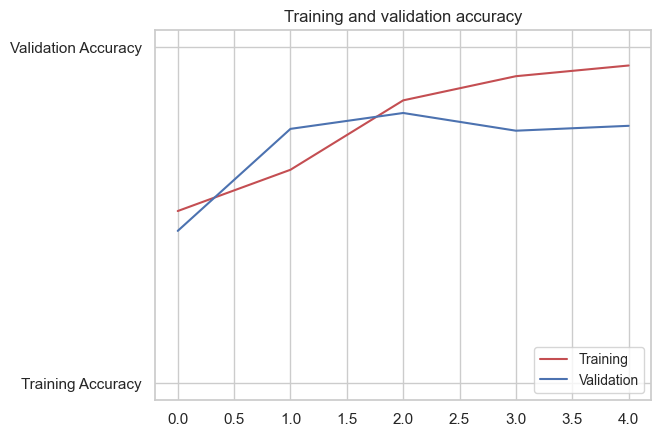

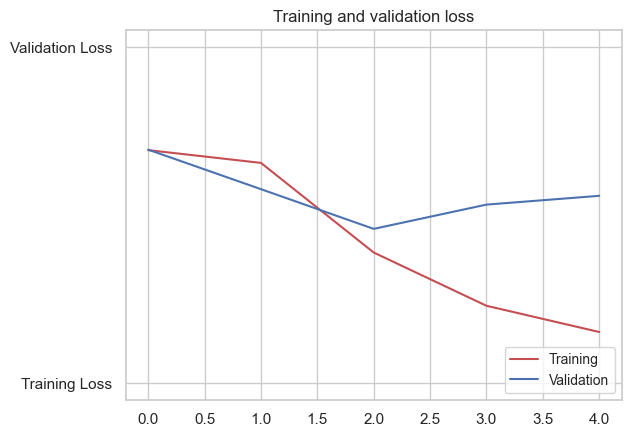

<Figure size 640x480 with 0 Axes>

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy', label="Training")
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy', label="Validation")
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Training", "Validation"], fontsize="small", loc="lower right")
plt.figure()

## B5. Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split (based on the industry average).

The following are the steps taken to prepare the data for sentiment analysis:

- combine data into  one dataframe using pd.concat()
- reset the index
- stopwords
- lemmatization
- normalization
- removal of special characters

Afterwards, the data set was split into train and test. The ratio used were 0.8 for the train set and 0.2 for the test set.

## B6. Provide a copy of the prepared data set.

In [42]:
# create dataframes of the prepared data set for export
df_X_training = pd.DataFrame(padded)
df_X_testing = pd.DataFrame(testing_padded)
df_y_training = pd.DataFrame(training_labels)
df_y_testing = pd.DataFrame(testing_labels)

# save the prepared data set
df_X_training.to_csv('../data/df_X_training.csv', index=False)
df_X_testing.to_csv('../data/df_X_testing.csv', index=False)
df_y_training.to_csv('../data/df_y_training.csv', index=False)
df_y_testing.to_csv('../data/df_y_testing.csv', index=False)

# Part III. Network Architecture

## C1. Provide the output of the model summary of the function from TensorFlow.

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 8)             39736     
                                                                 
 bidirectional (Bidirection  (None, 64)                10496     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 52105 (203.54 KB)
Trainable params: 52105 (203.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

## C2. Discuss the number of layers, the type of layers, and the total number of parameters.

The final model has 5 layers and a  total parameters of 61,833. There's three dense layers, one embedding, and one bidirectional.

## C3. Justify the choice of hyperparameters, including the following elements:

- activation functions: The rectified linear unit or ReLU function because it "is trivial to implement, requiring only a max() function" (Krishnamurthy, 2022). For the last layer, we used the sigmoid activation function because our sentiment analysis is a binary classification problem. 
- number of nodes per layer: The number of nodes per layer were selected through "systematic experimentation" as described by Brownlee in 2019.
- loss function: The binary_crossentropy was used because this particular classification problem is a binary one.
- optimizer: The optimizer used is Adam (Adaptive Moment Estimation) which "can be viewed as a fusion of momentum-based stochastic gradient descent and RMSprop" (Aayushmohansinha, n.d.).
- stopping criteria: The monitor used is val_loss because minimizing loss is better for this analysis.
- evaluation metric: For this analysis, accuracy was used to evaluate the model. It was chosen for simplicity and intuitiveness.

# Part IV: Model Evaluation

## D1. Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.

Instead of training up to 20 epochs, the early_stopping hyper parameter enabled training to stop at epoch number 5.

Epoch 5/20
69/69 [==============================] - 1s 18ms/step - loss: 0.1615 - accuracy: 0.9395 - val_loss: 0.5453 - val_accuracy: 0.7909

## D2. Assess the fitness of the model and any actions taken to address overfitting.

The model shows some overfitting. Changes such as adding a layer and adjusting hyperparameters were attemped but yielded no siginicant change in accuracy. Adding a dropout layer was attempted but did not affect significant change in accuracy.

## D3. Provide visualizations of the model’s training process, including a line graph of the loss and chosen evaluation metric.

The line graph of the accuracy and loss are displayed as the output of cell 41.

## D4.  Discuss the predictive accuracy of the trained network using the chosen evaluation metric from part D3.

The final model yielded 93.95% accuracy on the testing data.

# Part V. Summary and Recommendations

## E. Provide the code you used to save the trained network within the neural network.

Filename: "D213 Performance Assessment Task 2 (Rev. 0).ipynb"

## F. Discuss the functionality of your neural network, including the impact of the network architecture.

A lot of hyperparameter tuning were attempted but in the end, the simplest of models yielded the best result. Even then, the final model showed evidence of overfitting so the impact of this model design is inconsequential.

## G. Recommend a course of action based on your results.

First and foremmost, increase the size of the training data set.  Second, use SOTA packages and libraries instead of relying on a neural network to perform the sentiment analysis.

# Part VI. Reporting

## H. Show your neural network in an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.

- Filename: "D213 Performance Assessment Task 2 (Rev. 0).pdf"


## I. Denote specific web sources you used to acquire segments of third-party code that was used to support the application.

- https://github.com/ecdedios/code-snippets/blob/main/notebooks/master.ipynb
- https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
- https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f
- https://favtutor.com/blogs/list-to-string-python
- https://medium.com/aubergine-solutions/scratching-surface-of-rnn-gru-and-lstm-with-example-of-sentiment-analysis-8dd4e748d426

## J. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

- https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences
- https://builtin.com/machine-learning/relu-activation-function
- https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network
- https://www.geeksforgeeks.org/adam-optimizer-in-tensorflow/

In [44]:
print('Succesful run!')

Succesful run!
